# Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization,
    Activation, Concatenate, GlobalAveragePooling2D, Dense, Input, Flatten, Dropout,
    RandomFlip, RandomRotation, RandomZoom
)
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt

2025-12-08 19:34:41.062874: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765222481.243138      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765222481.295810      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

# General Configuration

In [2]:
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32
BASE_LEARNING_RATE = 1e-4 # Reduced LR for stability with Aux classifiers
EPOCHS = 40 # Increased epochs for better convergence


# Download Dataset

In [3]:
DATASET_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
DATA_DIR_RAW = tf.keras.utils.get_file(
    origin=DATASET_URL,
    fname="flower_photos",
    untar=True
)

DATA_DIR = pathlib.Path(DATA_DIR_RAW) / "flower_photos"
print(f"Data directory: {DATA_DIR}")

IMAGE_COUNT = len(list(DATA_DIR.glob("*/*.jpg")))
CLASS_NAMES = np.array(sorted([item.name for item in DATA_DIR.glob("*") if item.name != "LICENSE.txt"]))
NUM_CLASSES = len(CLASS_NAMES)

print(f"Image count: {IMAGE_COUNT}")
print(f"Class names: {CLASS_NAMES}")
print(f"Number of classes: {NUM_CLASSES}")

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Data directory: /root/.keras/datasets/flower_photos/flower_photos
Image count: 3670
Class names: ['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']
Number of classes: 5


# Load Dataset

In [4]:
def preprocess_input(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, {'main_output': label, 'aux1': label, 'aux2': label}

# Data Augmentation Layer (Part of the model or pipeline)
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
])

# Create Datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR, validation_split=0.2, subset="training", seed=123,
    image_size=IMAGE_SHAPE, batch_size=BATCH_SIZE
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR, validation_split=0.2, subset="validation", seed=123,
    image_size=IMAGE_SHAPE, batch_size=BATCH_SIZE
)

# Apply Augmentation to Train DS ONLY
# Note: Using map with lambda to apply augmentation layer
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)

# Apply Preprocessing (Normalization + Label Dict)
train_ds = train_ds.map(preprocess_input, num_parallel_calls=tf.data.AUTOTUNE).shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess_input, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.


I0000 00:00:1765222499.916610      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765222499.917248      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 3670 files belonging to 5 classes.
Using 734 files for validation.


# InceptionV1

In [5]:
# Basic Convolution
def conv_bn_relu(x, filters, kernel_size, strides=1, padding="same"):
    x = Conv2D(filters, kernel_size, strides=strides, padding=padding, use_bias=False)(x)
    x = BatchNormalization()(x)
    return Activation("relu")(x)

# Inception Blockl
def inception_block(x, f1, f3r, f3, f5r, f5, pp):
    """
    Inception V1 block.
    f1  = #filters 1x1 branch
    f3r = #filters 1x1 before 3x3 branch
    f3  = #filters 3x3
    f5r = #filters 1x1 before 5x5 branch
    f5  = #filters 5x5
    pp  = #filters 1x1 projection after pooling branch
    """
    # Branch 1 => 1x1
    b1 = conv_bn_relu(x=x, filters=f1, kernel_size=1)

    # Branch 2
    b2 = conv_bn_relu(x=x, filters=f3r, kernel_size=1)
    b2 = conv_bn_relu(x=b2, filters=f3, kernel_size=3)

    # Branch 3
    b3 = conv_bn_relu(x=x, filters=f5r, kernel_size=1)
    b3 = conv_bn_relu(x=b3, filters=f5, kernel_size=5)

    # Branch 4
    b4 = MaxPooling2D(pool_size=3, strides=1, padding="same")(x)
    b4 = conv_bn_relu(x=x, filters=pp, kernel_size=1)

    return Concatenate(axis=-1)([b1, b2, b3, b4])

# Auxiliary Classifier
def aux_classifier(x, num_classes, name):
    aux = AveragePooling2D(5, strides=3)(x)
    aux = conv_bn_relu(aux, 128, 1)
    aux = Flatten()(aux)
    aux = Dense(1024, activation='relu')(aux)
    aux = Dropout(0.7)(aux) # High dropout for aux as per paper
    aux = Dense(num_classes, activation="softmax", name=name)(aux)
    return aux


def googlenet_v1(input_shape=(224, 224, 3), num_classes=1000):
    inputs = Input(shape=input_shape)

    # Stem
    x = conv_bn_relu(x=inputs, filters=64, kernel_size=7, strides=2)
    x = MaxPooling2D(pool_size=3, strides=2, padding="same")(x)

    x = conv_bn_relu(x, 64, 1)
    x = conv_bn_relu(x, 192, 3)
    x = MaxPooling2D(pool_size=3, strides=2, padding="same")(x)

    # Group 1
    # Inception 3a
    x = inception_block(x, f1=64, f3r=96, f3=128, f5r=16, f5=32, pp=32)
    # Inception 3b
    x = inception_block(x, f1=128, f3r=128, f3=192, f5r=32, f5=96, pp=64)
    x = MaxPooling2D(pool_size=3, strides=2, padding="same")(x)

    # Group 2
    # Inception 4a
    x = inception_block(x, f1=192, f3r=96, f3=208, f5r=16, f5=48, pp=64)
    aux1 = aux_classifier(x, num_classes, name="aux1")

    # Inceptopn 4b
    x = inception_block(x, f1=160, f3r=112, f3=224, f5r=24, f5=64, pp=64)

    # Inception 4c
    x = inception_block(x, f1=128, f3r=128, f3=256, f5r=24, f5=64, pp=64)

    # Inceptopn 4d
    x = inception_block(x, f1=112, f3r=144, f3=288, f5r=32, f5=64, pp=64)
    aux2 = aux_classifier(x, num_classes, name="aux2")

    # Inception 4e
    x = inception_block(x, f1=256, f3r=160, f3=320, f5r=32, f5=128, pp=128)
    x = MaxPooling2D(pool_size=3, strides=2, padding="same")(x)

    # Inception 5a
    x = inception_block(x, f1=256, f3r=160, f3=320, f5r=32, f5=128, pp=128)

    # Inception 5b
    x = inception_block(x, f1=384, f3r=192, f3=384, f5r=48, f5=128, pp=128)

    # Classification
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    main_output = Dense(num_classes, activation="softmax", name="main_output")(x) # Named main output

    # Model now returns multiple outputs: main_output, aux1, aux2
    model = Model(inputs=inputs, outputs=[main_output, aux1, aux2], name="googlenet_v1")
    return model

model = googlenet_v1()
model.summary()

Model: "googlenet_v1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,408 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │      4,096 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │    110,592 │ activation_1[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        768 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 28, 28,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 28, 28,    │     18,432 │ max_pooling2d_1[… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 28,    │      3,072 │ max_pooling2d_1[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        384 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │         64 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 28, 28,    │          0 │ batch_normalizat

 Total params: 13,400,888 (51.12 MB)

 Trainable params: 13,385,816 (51.06 MB)

 Non-trainable params: 15,072 (58.88 KB)

## InceptionV1 Instance

In [6]:
model = googlenet_v1(input_shape=(224, 224, 3), num_classes=NUM_CLASSES)

# Losses
losses = {
    'main_output': 'sparse_categorical_crossentropy',
    'aux1': 'sparse_categorical_crossentropy',
    'aux2': 'sparse_categorical_crossentropy'
}

# Loss Weights
loss_weights = {'main_output': 1.0, 'aux1': 0.3, 'aux2': 0.3}

# Metrics (اینجا تغییر کرد: استفاده از دیکشنری برای هر ۳ خروجی)
metrics = {
    'main_output': 'accuracy',
    'aux1': 'accuracy',
    'aux2': 'accuracy'
}

# Compile
model.compile(
    optimizer=Adam(learning_rate=BASE_LEARNING_RATE),
    loss=losses,
    loss_weights=loss_weights,
    metrics=metrics
)

## Training

In [7]:
print(f"Starting model training for {EPOCHS} epochs...")
# Callbacks
allbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        'best_googlenet.keras',
        monitor='val_main_output_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_main_output_accuracy',
        patience=10,
        restore_best_weights=True,
        mode='max'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_main_output_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

print("Starting Training...")
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=allbacks # Corrected from 'callbacks' to 'allbacks'
)

Starting model training for 40 epochs...
Starting Training...
Epoch 1/40


I0000 00:00:1765222548.332592     107 service.cc:148] XLA service 0x7e22b8015970 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765222548.333434     107 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1765222548.333457     107 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1765222552.655522     107 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/92 ━━━━━━━━━━━━━━━━━━━━ 2:03:35 81s/step - aux1_accuracy: 0.2188 - aux1_loss: 2.1466 - aux2_accuracy: 0.2188 - aux2_loss: 2.4893 - loss: 3.3858 - main_output_accuracy: 0.1875 - main_output_loss: 1.9951

I0000 00:00:1765222586.158087     107 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - aux1_accuracy: 0.3558 - aux1_loss: 1.7463 - aux2_accuracy: 0.3644 - aux2_loss: 1.7464 - loss: 2.4762 - main_output_accuracy: 0.4319 - main_output_loss: 1.4307
Epoch 1: val_main_output_accuracy improved from -inf to 0.23978, saving model to best_googlenet.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 145s 693ms/step - aux1_accuracy: 0.3567 - aux1_loss: 1.7437 - aux2_accuracy: 0.3653 - aux2_loss: 1.7437 - loss: 2.4727 - main_output_accuracy: 0.4327 - main_output_loss: 1.4288 - val_aux1_accuracy: 0.2398 - val_aux1_loss: 2.2053 - val_aux2_accuracy: 0.2398 - val_aux2_loss: 1.8023 - val_loss: 3.7127 - val_main_output_accuracy: 0.2398 - val_main_output_loss: 2.5093 - learning_rate: 1.0000e-04
Epoch 2/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - aux1_accuracy: 0.5750 - aux1_loss: 1.1174 - aux2_accuracy: 0.5840 - aux2_loss: 1.0842 - loss: 1.6527 - main_output_accuracy: 0.6157 - main_output_loss: 0.9923
Epoch 2: val_main_output_accuracy did not improve from 0.23978

# Evaluation

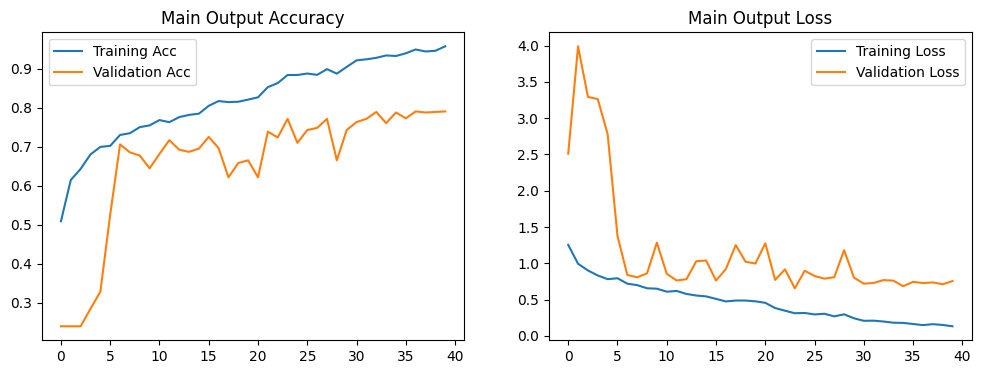

In [8]:
acc = history.history['main_output_accuracy']
val_acc = history.history['val_main_output_accuracy']
loss = history.history['main_output_loss']
val_loss = history.history['val_main_output_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Acc')
plt.plot(val_acc, label='Validation Acc')
plt.title('Main Output Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Main Output Loss')
plt.legend()
plt.show()